In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('train.tsv', sep='\t')

# General informations about the dataset

In [60]:
print(df.keys())
print(df['category'].value_counts())
print(df.head())

Index(['category', 'headline', 'text', 'url'], dtype='object')
category
sports        350
business      350
politics      350
health        350
technology     76
Name: count, dtype: int64
   category                                           headline  \
0    sports         L'Ouganda à l'assaut des "fimbu" de la RDC   
1  business  Stopper la détérioration de l’environnement po...   
2    sports  Coupe d'Afrique des nations 2022 : le sélectio...   
3  business  Tissus africains : pourquoi les teintureries h...   
4  business  Les revenus pendant la pandémie des dix hommes...   

                                                text  \
0  L'Ouganda, placé 79e au classement FIFA le 4 a...   
1  La responsable de la biodiversité des Nations ...   
2  Le sélectionneur de la Sierra Leone, John Keis...   
3  Depuis plus de six siècles, une vaste zone sit...   
4  Pendant la pandémie de coronavirus, la richess...   

                                                 url  
0        https://www.bb

In [61]:
# Balancing the dataset
import random

# Multiply by 4 each line of tech category
aug_df = df.copy()
for i in range(4):
    tech = df[df['category'] == 'technology']
    aug_df = pd.concat([aug_df, tech], ignore_index=True)

# sports        350
# business      350
# politics      350
# health        350
# technology    380

# remove 30 random lines in tech category
for i in range(30):
    aug_df = aug_df.drop(random.choice(
        aug_df[aug_df['category'] == 'technology'].index))

In [62]:
print(aug_df.keys())
print(aug_df['category'].value_counts())
print(aug_df.head())

Index(['category', 'headline', 'text', 'url'], dtype='object')
category
sports        350
business      350
politics      350
health        350
technology    350
Name: count, dtype: int64
   category                                           headline  \
0    sports         L'Ouganda à l'assaut des "fimbu" de la RDC   
1  business  Stopper la détérioration de l’environnement po...   
2    sports  Coupe d'Afrique des nations 2022 : le sélectio...   
3  business  Tissus africains : pourquoi les teintureries h...   
4  business  Les revenus pendant la pandémie des dix hommes...   

                                                text  \
0  L'Ouganda, placé 79e au classement FIFA le 4 a...   
1  La responsable de la biodiversité des Nations ...   
2  Le sélectionneur de la Sierra Leone, John Keis...   
3  Depuis plus de six siècles, une vaste zone sit...   
4  Pendant la pandémie de coronavirus, la richess...   

                                                 url  
0        https://www.bb

## Let's see how the length of the headlines and texts are distributed

<Axes: ylabel='Frequency'>

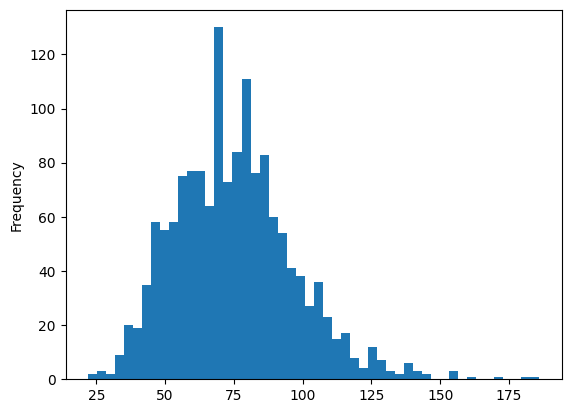

In [63]:
df['headline'].apply(len).plot.hist(bins=50)

<Axes: ylabel='Frequency'>

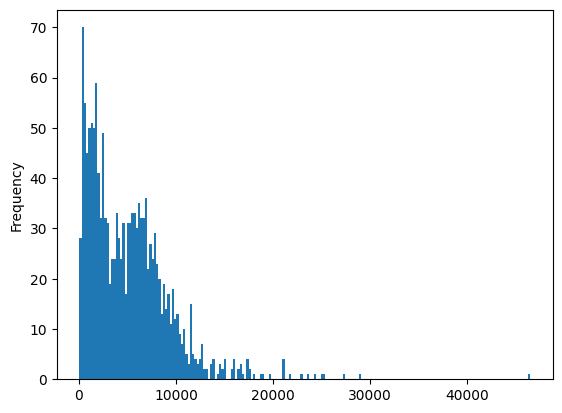

In [64]:
df["text"].apply(len).plot.hist(bins=200)

### Findings
- Url not relevant, we can drop this column
- Technology is clearly underrepresented in the dataset (1/5 of the support of other categories)
- texts lengths are in the range 0-10_000 characters, very small minority goes up to 40_000 chars.

We will need to take those informations into account to train the best model possible.

# Vectorizing

In [65]:
X = df[['headline', 'text']]
y = df["category"]

X_train, y_train = X, y

In [66]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

nltk.download("stopwords")
nltk.download('punkt')

french_stopwords = stopwords.words(
    'french') + list(string.punctuation) + ["''", '``', '...', '’', '``', '«', '»', '``']

vectorizer = TfidfVectorizer(tokenizer=lambda x: word_tokenize(x, language='french'),
                             stop_words=french_stopwords,
                             max_features=1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spoto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spoto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
res_desc = vectorizer.fit_transform(X_train['headline'].head())
desc_bow = pd.DataFrame(res_desc.toarray(), columns=vectorizer.get_feature_names_out())
desc_bow

,2022,a,africains,coupe,d'acheter,d'afrique,dix,détérioration,environnement,fermeture,...,révèle,sauver,selon,sierra,stopper,sélectionneur,teintureries,tissus,tous,vaccins
0,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.377964,0.377964,0.000000,...,0.00000,0.377964,0.377964,0.00000,0.377964,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.27735,0.27735,0.000000,0.27735,0.000000,0.27735,0.000000,0.000000,0.000000,0.000000,...,0.27735,0.000000,0.000000,0.27735,0.000000,0.27735,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.00000,0.333333,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.333333,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.333333,0.333333,0.000000,0.000000
4,0.00000,0.00000,0.000000,0.00000,0.288675,0.00000,0.288675,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.288675,0.288675


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

col_trans = ColumnTransformer(
    [('headline', vectorizer, 'headline'),
     ('text', vectorizer, 'text')],
)

pipe = make_pipeline(col_trans, RandomForestClassifier())

In [69]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('headline',
                                                  TfidfVectorizer(max_features=1000,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                              'en',
                                                                              'et',
                                                                              'eux',
                                                                              'il',
                                                                              'ils',
                                                                              'je',
                                                                              'la',
                                                                              'le',
                                                                              'les',
                                                                              'leur',
                                                                              'lui',
                                                                              'ma',
                                                                              'mais',
                                                                              'me',
                                                                              'même',
                                                                              'mes',
                                                                              'moi',
                                                                              'mon',
                                                                              'ne',
                                                                              'nos', ...],
                                                                  tokenizer=<function <lambda> at 0x00000200C1B140...
                                                  'headline'),
                                                 ('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
                                                                              'dans',
                                                                              'de',
                                                                              'des',
                                                                              'du',
                                                                              'elle',
                                                                              'en',
         

In [70]:
df_test = pd.read_csv('test.tsv', sep='\t')

# show count of each category
print(df_test['category'].value_counts())

X_test = df_test[['headline', 'text']]
y_test = df_test["category"]

category
business      100
health        100
politics      100
sports        100
technology     22
Name: count, dtype: int64


In [71]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.61      0.74      0.67       100
      health       0.86      0.90      0.88       100
    politics       0.77      0.79      0.78       100
      sports       0.95      0.87      0.91       100
  technology       1.00      0.05      0.09        22

    accuracy                           0.78       422
   macro avg       0.84      0.67      0.66       422
weighted avg       0.81      0.78      0.77       422



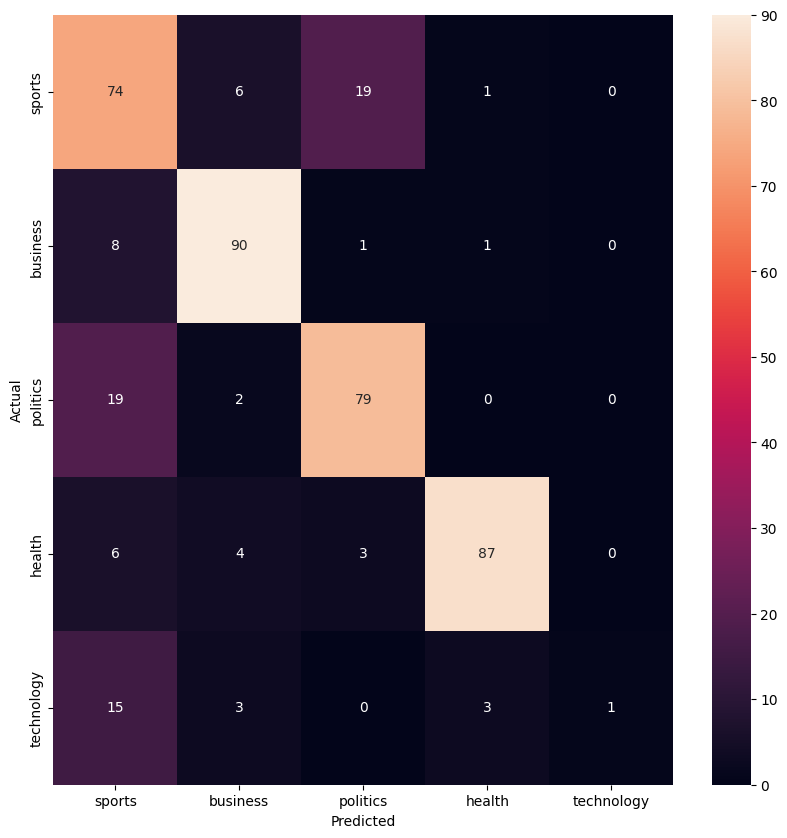

In [72]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Let's see what type of model is better

In [73]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Multinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier())
]

for name, model in models:
    pipe = make_pipeline(col_trans, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'{name}: {accuracy_score(y_test, y_pred)}')

Baseline: 0.23696682464454977
Mutinomial NB: 0.8293838862559242
CART: 0.6658767772511849
LR: 0.8412322274881516
KNN: 0.5924170616113744
Random forest: 0.7796208530805687


# Spacy magic

L'Ouganda à l'assaut des "fimbu" de la RDC
Stopper la détérioration de l’environnement pour sauver la planète selon l’ONU
Coupe d'Afrique des nations 2022 : le sélectionneur de la Sierra Leone révèle les menaces de mort qu'il a reçues
Tissus africains : pourquoi les teintureries historiques du Nigéria, à Kano, risquent la fermeture
Les revenus pendant la pandémie des dix hommes les plus riches "pourraient permettre d'acheter des vaccins pour tous"
Guerre Ukraine - Russie : les Etats-Unis critiquent la neutralité des pays africains
Symptômes Coronavirus : combien de temps faut-il pour guérir ?
Félicien Kabuga : le financier présumé du génocide rwandais arrêté en France
Joe Ligon, le "mineur condamné à la plus longue peine aux États-Unis"
Changement climatique : cinq choses surprenantes qui ont un impact sur la planète
Qui est Saleh Kebzabo le nouveau Premier ministre du Tchad, et quels sont les défis qui l'attendent ?
Guerre Ukraine - Russie : pourquoi Vladimir Poutine n'aurait pas pu e